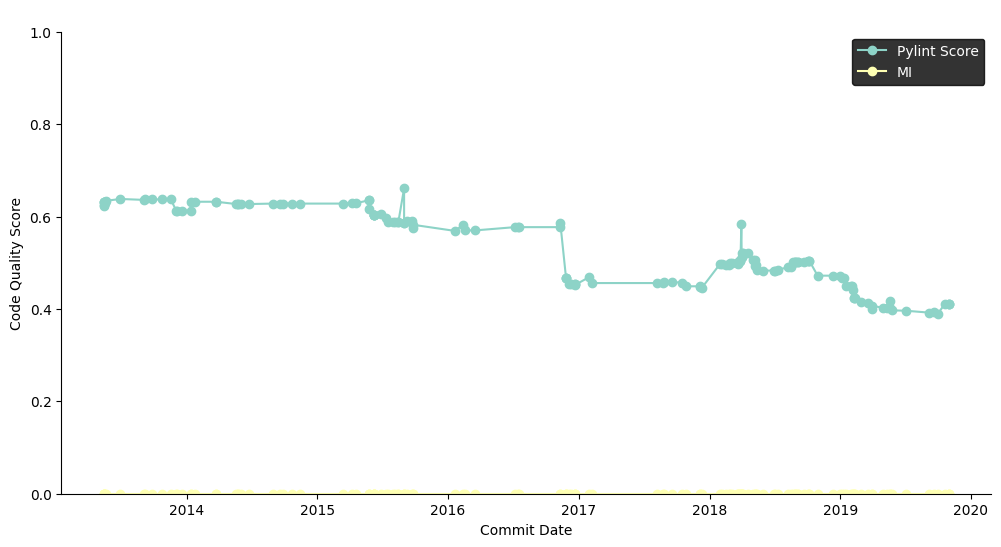

In [3]:
from build.code_quality_visualizer import plot_file_code_quality

plot_file_code_quality("lib/matplotlib/pyplot.py", "matplotlib", ["pylint_score", "mi"])

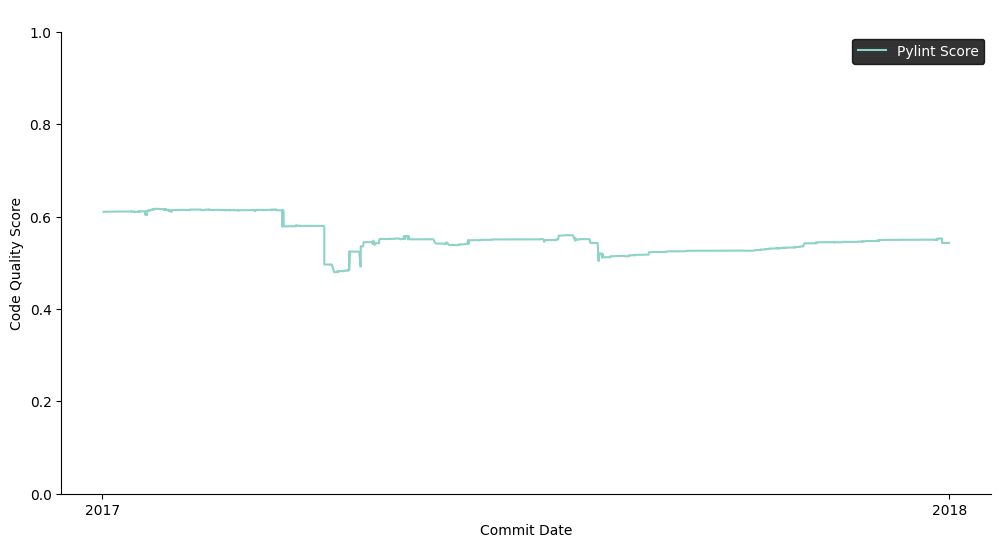

In [2]:
from build.code_quality_visualizer import plot_repo_code_quality_fast

plot_repo_code_quality_fast("matplotlib", "2017")

In [ ]:
# TODO Finish coding and testing method when needed
from matplotlib.colors import hex2color
from build.code_quality_analyzer import calculate_maintainability_index, get_attribute_value_at_time
from build.database_handler import get_object
from datetime import datetime
from matplotlib import pyplot as plt

def plot_pull_request_code_quality(pull_request_id, collection, metric_names=[]):
    """
    Plot the code quality metrics for a specific pull request in the repository
    Args:
        pull_request_id (str): The ID of the pull request to plot the code quality metrics for
        collection (str): The name of the collection (i.e., repository) to get the metrics from.
        metric_names (list, optional): The list of metric names to include in the plot
    """
    if metric_names == []:
        print("No metric names provided, using only loc")
        metric_names = ["sloc"]

    pull_request = get_object(pull_request_id, collection)
    if not pull_request:
        print(f"Pull request with ID {pull_request_id} not found in collection {collection}.")
        return
    metrics = {}
    input_metrics = []
    if "mi" in metric_names:
        input_metrics = (["cc", "theta_1", "theta_2", "N_1", "N_2", "sloc"] + metric_names) # TODO Fix error where MI is in wrong order
    else: 
        input_metrics = metric_names
    default_metric_structure = {}
    for metric in input_metrics:
        default_metric_structure[metric] = None

    for relationship in pull_request["relationships"]:
        commit, file_object = None, None
        if relationship["qualifier"] == "formalises":
            commit = get_object(relationship["qualifier"], collection)
        elif relationship["qualifier"] == "aggregates":
            file_object = get_object(relationship["qualifier"], collection)
        if commit is not None and len(commit["attributes"]) > 0:
            commit_time = datetime.fromisoformat(commit["attributes"][0]["time"]).replace(tzinfo=None)
            metrics[commit_time] = default_metric_structure.copy()
        else:
            commit_time = datetime.now() # TODO Test if code can actually show wrong time

        if file_object is not None and file_object["_id"].find(".py") != -1:
            for metric, metric_value in metrics[commit_time].items():
                if metric_value is None and metric != "mi":
                    metrics[commit_time][metric] = get_attribute_value_at_time(file_object["_id"], metric, commit_time, collection) 
                elif metric == "mi":
                    if all(metrics[commit_time][m] is not None for m in input_metrics if m != "mi"):
                        metrics[commit_time][metric] = calculate_maintainability_index(
                            metrics[commit_time]["N_1"],
                            metrics[commit_time]["N_2"],
                            metrics[commit_time]["theta_1"],
                            metrics[commit_time]["theta_2"],
                            metrics[commit_time]["cc"],
                            metrics[commit_time]["sloc"]
                        )/100
                    else: 
                        print(f"ERROR: Not all required metrics for MI calculation are available at {commit_time}.")
            # Get all files modified in all commits and then create average of metrics for files per commit
    
    plt.figure(figsize=(12, 6))
    plt.xlabel("Commit Date")
    plt.ylabel("Code Quality Score")
    plt.title(f"Code Quality Metrics Over Time for PR#{pull_request['_id']}")
    plt.ylim(0, 1.1)

    plt.legend()
    plt.show()

plot_pull_request_code_quality("30348", "matplotlib", ["pylint_score", "mi", "cc", "theta_1", "theta_2", "N_1", "N_2", "sloc"])

In [1]:
# Start point for testing pull request related viualisations
from build.database_handler import get_pull_requests

collection = "edx-platform"

pull_requests = get_pull_requests(collection)
ids = [pull_request["_id"] for pull_request in pull_requests]

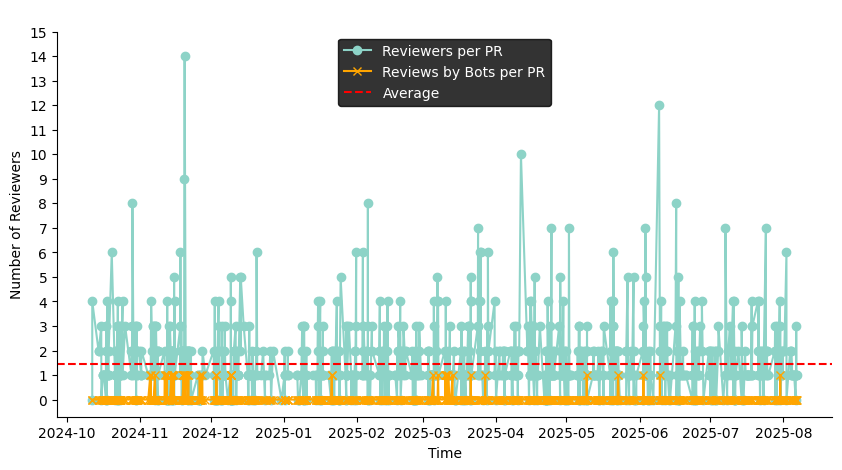

In [3]:
from build.contribution_process_analyzer import pull_request_reviewer_analysis

pull_request_reviewer_analysis(ids, collection, True)

<Figure size 1000x500 with 0 Axes>

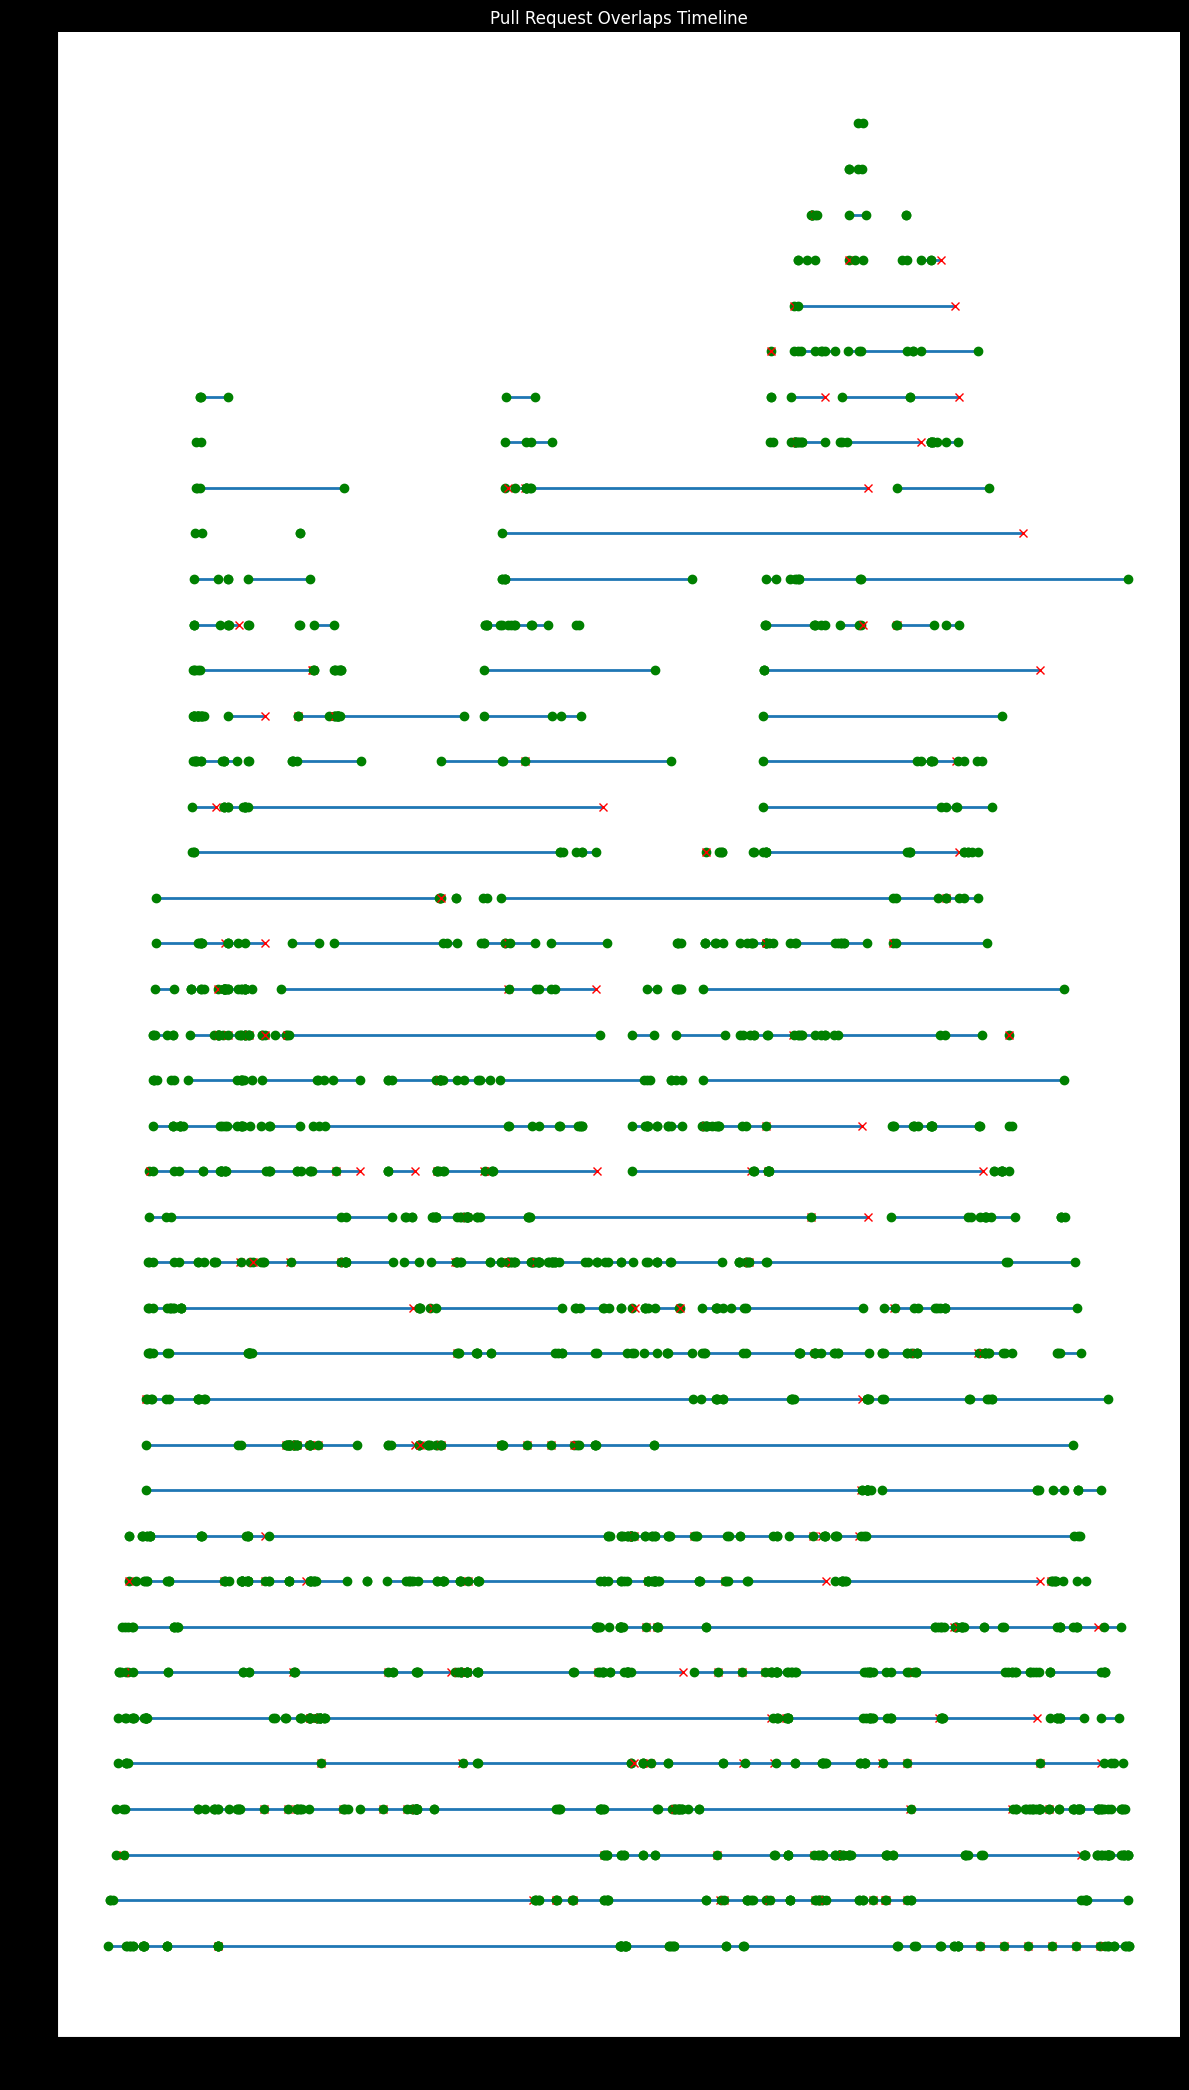

In [5]:
from build.contribution_process_analyzer import pull_request_open_time_analysis

pull_request_open_time_analysis(ids, collection, True)

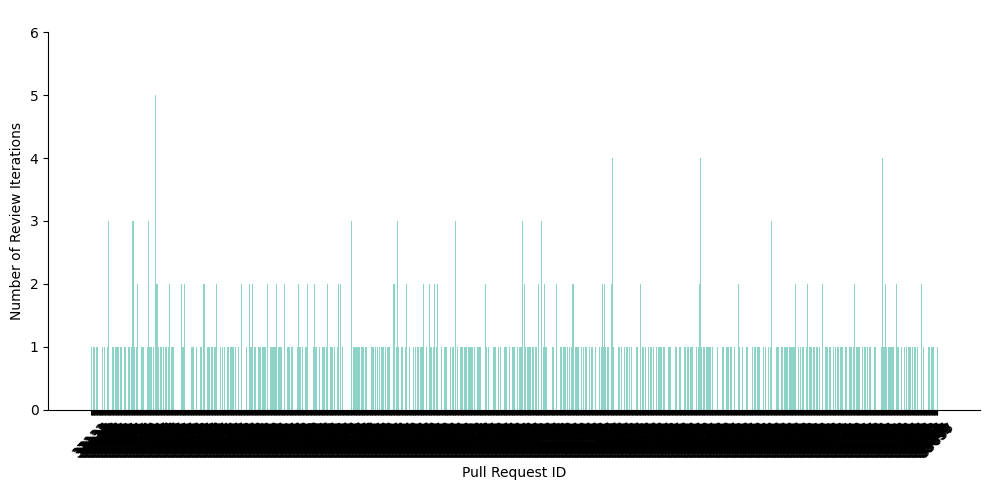

In [4]:
from build.contribution_process_analyzer import pull_request_review_iterations

pull_request_review_iterations(ids, collection, True)

In [ ]:
import json
from build.contribution_process_miner import flatten_ocel2

collection = "edx-platform"

path = f"/Users/as/Library/Mobile Documents/com~apple~CloudDocs/Dokumente/Studium/Bachelor-Thesis/Bachelor-Code/Exports/{collection}-OCEL.json"

with open(path) as f:
    ocel = json.load(f)

res = flatten_ocel2(ocel, "pull_request", collection)

ERROR: No object found for id: Muhammad Faraz  Maqsood
ERROR: No object found for id: ea7100b2281f4acbabd99c2ea5da0e0ad00a9e2d
ERROR: No object found for id: sumair-arbisoft
ERROR: No object found for id: 34ab6d629e415645ceb868224896e5a324b48ccf
ERROR: No object found for id: GitHub
ERROR: No object found for id: defee1626145fe84c170c3e327e7cd6bc910537b
ERROR: No object found for id: GitHub
ERROR: No object found for id: 2f49b8174dad1b3eddd54979e34e402894e94209
ERROR: No object found for id: sarina
ERROR: No object found for id: 13769e1573e8b7a863a01991eb19de40d4634fdc
ERROR: No object found for id: 5a42d35a457c7715dd85b5a5e39027de986fd70e
ERROR: No object found for id: GitHub
ERROR: No object found for id: e445d8adadf3f00dcf0a93f770a87226240a812e
ERROR: No object found for id: GitHub
ERROR: No object found for id: 46c3616b225e24fe86d6225b8be431ede9ecc391
ERROR: No object found for id: GitHub
ERROR: No object found for id: 7ecd6a54af4b77e6f6e56578479596df600ec63b
ERROR: No object found

/Users/as/Library/Mobile Documents/com~apple~CloudDocs/Dokumente/Studium/Bachelor-Thesis/Bachelor-Code/build/contribution_process_miner.py:111: FutureWarning: Parsed string "2025-08-06T15:20:39ZZ" included an un-recognized timezone "ZZ". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df["time:timestamp"] = pd.to_datetime(df["time:timestamp"], utc=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
exporting log, completed traces :: 100%|██████████| 1164/1164 [00:00<00:00, 1674.36it/s]
